# **Vehicle Detection and Tracking** 
***
TBD

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## 1 Prepare a vehicle/non-vehilce classifier

### 1.1 Image Read-in

In [2]:
# read in all the image file names 
cars_Far         = glob.glob('vehicles/vehicles/GTI_Far/*.png') 
cars_Left        = glob.glob('vehicles/vehicles/GTI_Left/*.png') 
cars_MiddleClose = glob.glob('vehicles/vehicles/GTI_MiddleClose/*.png') 
cars_Right       = glob.glob('vehicles/vehicles/GTI_Right/*.png')
cars_KITTI       = glob.glob('vehicles/vehicles/KITTI_extracted/*.png')
cars = np.hstack((cars_Far,cars_Left,cars_MiddleClose,cars_Right,cars_KITTI))

notcars_GTI       = glob.glob('non-vehicles/non-vehicles/GTI/*.png') 
notcars_Extras    = glob.glob('non-vehicles/non-vehicles/Extras/*.png') 
notcars           = np.hstack((notcars_GTI,notcars_Extras))


In [3]:
#print(type(cars))
#print(len(cars))
#print(cars[1000])
print(cars.shape)
#print(type(notcars))
#print(len(notcars))
#print(notcars[1000])

(8792,)


In [4]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    #
    data_dict["data_max"] = np.max(example_img)
    # Return data_dict
    return data_dict

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type:  float32  with max data:  0.752941


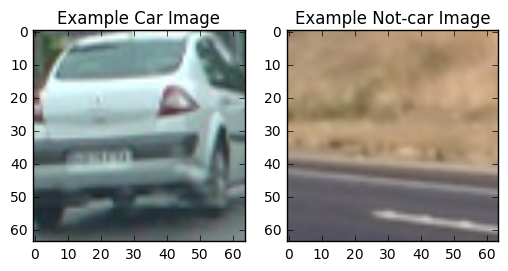

In [5]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type: ', 
      data_info["data_type"], ' with max data: ',data_info["data_max"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

### 1.2 Feature Selection

In [6]:
# extract features of a image

from skimage.feature import hog

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features
                        
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



In [7]:
# Define a function to extract features from a list of images (image file names)
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

### 1.3 Data Preparation
---
perform 1) feature extraction 2) feature normalization 3) data labeling 4) data random shuffling

In [8]:
from sklearn.preprocessing import StandardScaler

# 1) feature extraction
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [400, 700] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

# 2) feature normalization
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)



(17760, 6156)


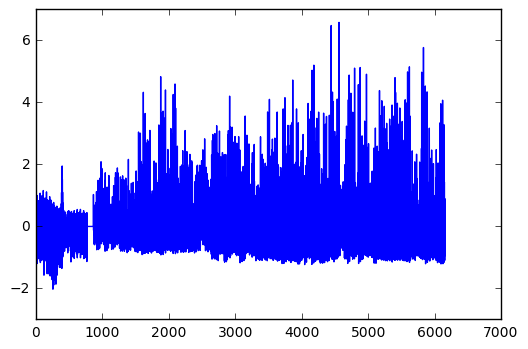

In [9]:
print(scaled_X.shape)
plt.plot(scaled_X[17700])

In [10]:
# 3) data labeling
# Define a labels vector based on features lists
y = np.hstack((np.ones(len(car_features)), 
              np.zeros(len(notcar_features))))

In [11]:
# 4) data shuffeling 
from sklearn.model_selection import train_test_split
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

### 1.4 Classifier Training

In [12]:
import time
from sklearn.svm import LinearSVC

print('Using spatial binning of:',spatial_size[0],
    'and', hist_bins,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC (support vector classifier)
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
# Train the SVC
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts    : ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 16 and 32 histogram bins
Feature vector length: 6156
15.63 Seconds to train SVC...
Test Accuracy of SVC =  0.9899
My SVC predicts    :  [ 0.  1.  1.  1.  0.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 0.  1.  1.  1.  0.  1.  0.  0.  0.  1.]
0.0 Seconds to predict 10 labels with SVC


## 2 Detect Vehicles

---


### 2.1 Detect vehicle regions with sliding windows

(720, 1280, 3)
255


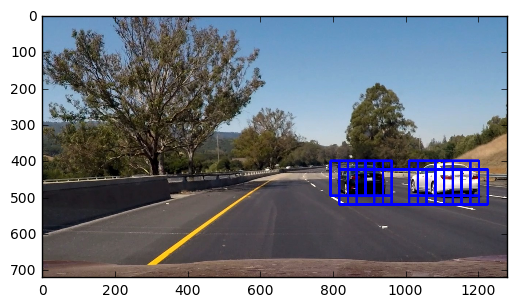

In [13]:
img = mpimg.imread('test_images/test6.jpg')
print(img.shape)
print(np.max(img))


# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    bbox_list = []
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                bbox_list.append(box)
                
    return [draw_img,bbox_list]
    
ystart = 400
ystop = 660
scale = 1.5
    
[out_img,box_list] = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)

### 2.2 Fuse multi-detection and create heat map

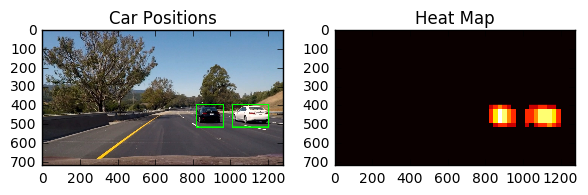

In [14]:
from scipy.ndimage.measurements import label

heat = np.zeros_like(img[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


In [15]:
print(type(labels))
print(len(labels))
print(type(labels[0]))
print(type(labels[1]))
print(labels[1])
print(labels[0].shape)
print(labels[0].dtype)
print(np.max(labels[0]))


<class 'tuple'>
2
<class 'numpy.ndarray'>
<class 'int'>
2
(720, 1280)
int32
2


### 2.3 Create vehicle detection pipeline

In [16]:

def data_associate(bbox):
      
    global bboxList_flt
       
    if len(bboxList_flt)==0:
        return -1
        
    THRESH_X = 100
    THRESH_Y = 100
    
    center = np.float32( ( (bbox[0][0]+bbox[1][0])/2, (bbox[0][1]+bbox[1][1])/2 ) )
                           
   
                          
    ind_associate = -1
    minDistSqr    = 720*720 + 1280*1280
    # iterate through bboxList_flt (filtered vehicles info)
    for ind in range(len(bboxList_flt)):
        bbox_info = bboxList_flt[ind]
        dx = bbox_info[0][0] - center[0] # center x
        dy = bbox_info[0][1] - center[1] # center y
        if np.abs(dx) < THRESH_X and np.abs(dy) < THRESH_Y:
            if dx*dx + dy*dy < minDistSqr:
                ind_associate = ind
                minDistSqr = dx*dx + dy*dy
        else: 
            continue 
    
    return ind_associate 
           
def predict():
    
    global bboxList_flt
    
    #flt_coeff = 0.1
    for i in range(len(bboxList_flt)):
        bboxList_flt[i][3]  = bboxList_flt[i][0]
        bboxList_flt[i][0] += bboxList_flt[i][1] # pos = pos_last + vel_last (pos is a 2d vector)
    
                        

# modify draw_labeled_bboxes function
def draw_labeled_bboxes_flt(img, labels):
                        
    
    global bboxList_flt
    THRESH_CNT = 3
    THRESH_LOSS_CNT = 30
    pos_flt_coeff = 0.3
    vel_flt_coeff = 0.1
    sz_flt_coeff  = 0.2
    # 1) predict the center position based on last step position and velocity
    predict()   
                        
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y 
        bbox     = ( (np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)) )
              
        # 2) data association
        ind_associate = data_associate(bbox)
        # if association success
        if ind_associate >-1:
            
            # 3) update
            
            bboxList_flt[ind_associate][-1] = True  # measured is true 
            bboxList_flt[ind_associate][-3] += 1    # count = count + 1
            
            # update position
            centerPos = np.float32( [ (bbox[0][0]+bbox[1][0])/2, (bbox[0][1]+bbox[1][1])/2 ] )
            bboxList_flt[ind_associate][0] =  pos_flt_coeff * centerPos + (1-pos_flt_coeff) * bboxList_flt[ind_associate][0]
            # update velocity
            centerVel =bboxList_flt[ind_associate][0] - bboxList_flt[ind_associate][3]
            bboxList_flt[ind_associate][1] =  vel_flt_coeff * centerVel + (1-vel_flt_coeff) * bboxList_flt[ind_associate][1]
            # update size
            size   = np.float32( [ bbox[1][0]-bbox[0][0], bbox[1][1]-bbox[0][1] ] )
            bboxList_flt[ind_associate][2] = sz_flt_coeff * size + (1-sz_flt_coeff) *bboxList_flt[ind_associate][2]
            
        else:
            # 4) new object 
            cntrPos = np.array( [(bbox[0][0]+bbox[1][0])/2, (bbox[0][1]+bbox[1][1])/2 ] )
            cntrVel = np.array([0,0]).astype(np.float32)
            size    = np.array( [bbox[1][0]-bbox[0][0], bbox[1][1]-bbox[0][1] ] ).astype(np.float32)
            cnt     = 1
            lossCnt = 0
            measured= True
            
            new_box = [cntrPos, cntrVel, size, cntrPos, cnt, lossCnt, measured]
            
            bboxList_flt.append(new_box)      
    
    #print(bboxList_flt)
    
    # 5) eliminate object not detected for too long
    boxList = []
    for i in range(len(bboxList_flt)):
        if not bboxList_flt[i][-1]:   # if not measured
            bboxList_flt[i][-2] += 1  # loss_cnt += 1
            
            print(bboxList_flt[i][-3])
            
        if ( bboxList_flt[i][-2] <= THRESH_LOSS_CNT and bboxList_flt[i][-3] > 5 )  or ( bboxList_flt[i][-2] <= 10 and bboxList_flt[i][-3] <= 5 )  or ( bboxList_flt[i][-2] <= 4*THRESH_LOSS_CNT and bboxList_flt[i][-3] > 200 ) :
            bboxList_flt[i][-1] = False # reset measured bit
            boxList.append(bboxList_flt[i])

    bboxList_flt = boxList    
    
    # Draw valid boxes on the image
    #for bbox in bboxList_flt:
        #cv2.rectangle(img, bbox[0], bbox[1], (0,255,0), 6)
        
    for i in range(len(bboxList_flt)):
        
        if bboxList_flt[i][-3] > THRESH_CNT:            
        
            centroid = bboxList_flt[i][0]
            size     = bboxList_flt[i][2]
            
            box_minX = int(centroid[0]-size[0]/2)
            box_maxX = int(centroid[0]+size[0]/2)
            box_minY = int(centroid[1]-size[1]/2)
            box_maxY = int(centroid[1]+size[1]/2)
            
            # Draw the box on the image
            cv2.rectangle(img, (box_minX,box_minY), (box_maxX,box_maxY), (0,255,0), 6)
    # Return the image
    
    return [img, bboxList_flt]
                        

In [17]:
# pipeline

#bboxInfo_flt = [] # bboxInfo_flt is a list of lists: [center,size,count,loss_cnt,measured], where center and size are numpy arrays 

def CarDetection_PipeLine(img):
    
    # global variables
    global bboxList_flt
    # bboxList_flt is a list of list: [centerPos, centerVel,size, centerPosLast, count,loss_cnt,measured], where center and size are numpy arrays 
     
    #
    scale = 1.5
    [out_img,box_list1] = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    scale = 2.0
    [out_img,box_list2] = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    box_list = box_list1 + box_list2
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    [draw_img, bboxList_flt] = draw_labeled_bboxes_flt(np.copy(img), labels)
    
    return draw_img

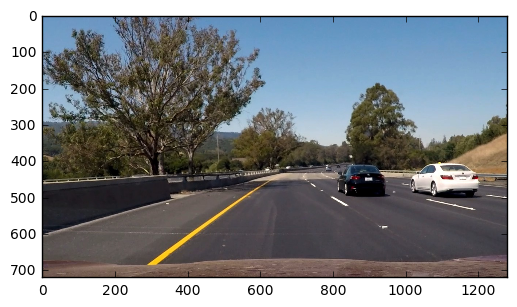

In [18]:
img = mpimg.imread('test_images/test6.jpg')

bboxList_flt = []

draw_img = CarDetection_PipeLine(img)
plt.imshow(draw_img)

## 3 Video Output

In [23]:
#
from moviepy.editor import VideoFileClip
from IPython.display import HTML

bboxList_flt = []

In [24]:
video_name = 'project_video'
white_output = video_name + '_output.mp4'
clip1 = VideoFileClip(video_name+'.mp4')
white_clip = clip1.fl_image(CarDetection_PipeLine) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


 17%|█▋        | 211/1261 [01:25<06:58,  2.51it/s]

48


 27%|██▋       | 336/1261 [02:14<06:10,  2.49it/s]

1


 27%|██▋       | 337/1261 [02:15<06:09,  2.50it/s]

1


 27%|██▋       | 338/1261 [02:15<06:12,  2.48it/s]

1


 27%|██▋       | 339/1261 [02:16<06:12,  2.48it/s]

1


 27%|██▋       | 340/1261 [02:16<06:10,  2.48it/s]

1


 27%|██▋       | 341/1261 [02:16<06:13,  2.47it/s]

1


 27%|██▋       | 342/1261 [02:17<06:11,  2.48it/s]

1


 27%|██▋       | 343/1261 [02:17<06:11,  2.47it/s]

1


 27%|██▋       | 344/1261 [02:18<06:09,  2.48it/s]

1


 27%|██▋       | 345/1261 [02:18<06:13,  2.45it/s]

1


 27%|██▋       | 346/1261 [02:18<06:09,  2.47it/s]

1


 37%|███▋      | 462/1261 [03:06<05:33,  2.40it/s]

298


 37%|███▋      | 463/1261 [03:07<05:28,  2.43it/s]

298


 41%|████      | 511/1261 [03:26<04:57,  2.52it/s]

345


 41%|████      | 513/1261 [03:27<04:56,  2.52it/s]

346


 41%|████      | 515/1261 [03:28<04:56,  2.51it/s]

347


 41%|████      | 516/1261 [03:28<04:56,  2.52it/s]

347


 41%|████▏     | 522/1261 [03:30<04:52,  2.53it/s]

352


 41%|████▏     | 523/1261 [03:31<04:52,  2.52it/s]

352


 42%|████▏     | 526/1261 [03:32<04:51,  2.52it/s]

354


 42%|████▏     | 527/1261 [03:32<04:50,  2.53it/s]

354


 42%|████▏     | 530/1261 [03:34<04:53,  2.49it/s]

1


 42%|████▏     | 531/1261 [03:34<04:51,  2.50it/s]

1


 42%|████▏     | 532/1261 [03:34<04:53,  2.48it/s]

1


 42%|████▏     | 533/1261 [03:35<04:51,  2.50it/s]

1


 42%|████▏     | 534/1261 [03:35<04:51,  2.49it/s]

1


 42%|████▏     | 535/1261 [03:36<04:51,  2.49it/s]

1


 43%|████▎     | 536/1261 [03:36<04:51,  2.48it/s]

1


 43%|████▎     | 537/1261 [03:36<04:49,  2.50it/s]

1


 43%|████▎     | 538/1261 [03:37<04:49,  2.50it/s]

1


 43%|████▎     | 539/1261 [03:37<04:49,  2.50it/s]

1


 43%|████▎     | 540/1261 [03:38<04:49,  2.49it/s]

1


 43%|████▎     | 546/1261 [03:40<04:44,  2.51it/s]

372


 44%|████▎     | 549/1261 [03:41<04:42,  2.52it/s]

374


 44%|████▎     | 551/1261 [03:42<04:43,  2.50it/s]

375


 44%|████▍     | 552/1261 [03:42<04:44,  2.49it/s]

375


 44%|████▍     | 553/1261 [03:43<04:42,  2.51it/s]

375


 44%|████▍     | 554/1261 [03:43<04:41,  2.51it/s]

375


 44%|████▍     | 556/1261 [03:44<04:43,  2.49it/s]

1


 44%|████▍     | 557/1261 [03:44<04:45,  2.46it/s]

377
1


 44%|████▍     | 558/1261 [03:45<04:45,  2.46it/s]

377
1


 44%|████▍     | 559/1261 [03:45<04:45,  2.46it/s]

377
1


 44%|████▍     | 560/1261 [03:46<04:43,  2.47it/s]

377
1


 44%|████▍     | 561/1261 [03:46<04:43,  2.47it/s]

377
1


 45%|████▍     | 562/1261 [03:46<04:43,  2.46it/s]

377
1


 45%|████▍     | 563/1261 [03:47<04:41,  2.48it/s]

377
1


 45%|████▍     | 564/1261 [03:47<04:42,  2.47it/s]

377
1


 45%|████▍     | 565/1261 [03:48<04:41,  2.47it/s]

1


 45%|████▍     | 566/1261 [03:48<04:39,  2.49it/s]

1


 45%|████▌     | 570/1261 [03:50<04:39,  2.48it/s]

382


 45%|████▌     | 571/1261 [03:50<04:36,  2.49it/s]

382


 45%|████▌     | 572/1261 [03:50<04:36,  2.49it/s]

382


 45%|████▌     | 573/1261 [03:51<04:34,  2.51it/s]

382


 46%|████▌     | 574/1261 [03:51<04:33,  2.51it/s]

382


 46%|████▌     | 575/1261 [03:52<04:33,  2.51it/s]

382


 46%|████▌     | 576/1261 [03:52<04:34,  2.50it/s]

382


 46%|████▌     | 577/1261 [03:52<04:32,  2.51it/s]

382


 46%|████▌     | 578/1261 [03:53<04:34,  2.48it/s]

382


 46%|████▌     | 579/1261 [03:53<04:32,  2.51it/s]

382


 46%|████▌     | 581/1261 [03:54<04:32,  2.49it/s]

383


 47%|████▋     | 587/1261 [03:56<04:33,  2.46it/s]

1


 47%|████▋     | 588/1261 [03:57<04:33,  2.46it/s]

1


 47%|████▋     | 589/1261 [03:57<04:32,  2.47it/s]

1


 47%|████▋     | 590/1261 [03:58<04:32,  2.46it/s]

391
1


 47%|████▋     | 591/1261 [03:58<04:30,  2.48it/s]

1


 47%|████▋     | 592/1261 [03:58<04:31,  2.46it/s]

1


 47%|████▋     | 593/1261 [03:59<04:31,  2.46it/s]

1


 47%|████▋     | 594/1261 [03:59<04:30,  2.47it/s]

1


 47%|████▋     | 595/1261 [04:00<04:31,  2.46it/s]

1


 47%|████▋     | 596/1261 [04:00<04:34,  2.42it/s]

1


 47%|████▋     | 597/1261 [04:01<04:31,  2.45it/s]

1


 48%|████▊     | 605/1261 [04:04<04:25,  2.47it/s]

405


 48%|████▊     | 606/1261 [04:04<04:23,  2.48it/s]

405


 48%|████▊     | 607/1261 [04:05<04:23,  2.48it/s]

405


 48%|████▊     | 608/1261 [04:05<04:24,  2.46it/s]

405


 48%|████▊     | 610/1261 [04:06<04:25,  2.45it/s]

406


 48%|████▊     | 611/1261 [04:06<04:26,  2.44it/s]

406


 49%|████▊     | 612/1261 [04:07<04:28,  2.42it/s]

406


 49%|████▊     | 613/1261 [04:07<04:38,  2.32it/s]

406


 49%|████▊     | 614/1261 [04:08<04:51,  2.22it/s]

406


 49%|████▉     | 615/1261 [04:08<04:40,  2.31it/s]

406


 49%|████▉     | 616/1261 [04:08<04:34,  2.35it/s]

406


 49%|████▉     | 617/1261 [04:09<04:45,  2.25it/s]

406


 49%|████▉     | 618/1261 [04:09<05:03,  2.12it/s]

406


 49%|████▉     | 619/1261 [04:10<04:53,  2.19it/s]

406


 49%|████▉     | 620/1261 [04:10<04:49,  2.21it/s]

406


 49%|████▉     | 621/1261 [04:11<04:47,  2.22it/s]

406


 49%|████▉     | 622/1261 [04:11<04:38,  2.29it/s]

406


 49%|████▉     | 623/1261 [04:12<04:42,  2.25it/s]

406


 49%|████▉     | 624/1261 [04:12<04:47,  2.21it/s]

406


 50%|████▉     | 625/1261 [04:13<04:48,  2.20it/s]

406


 50%|████▉     | 626/1261 [04:13<04:40,  2.27it/s]

406


 50%|████▉     | 627/1261 [04:13<04:41,  2.25it/s]

406


 50%|████▉     | 628/1261 [04:14<04:47,  2.20it/s]

406


 50%|████▉     | 629/1261 [04:14<04:35,  2.29it/s]

406


 50%|████▉     | 630/1261 [04:15<04:28,  2.35it/s]

406


 50%|█████     | 631/1261 [04:15<04:31,  2.32it/s]

406


 50%|█████     | 632/1261 [04:16<04:26,  2.36it/s]

406


 50%|█████     | 633/1261 [04:16<04:21,  2.40it/s]

406


 50%|█████     | 634/1261 [04:16<04:19,  2.42it/s]

406


 50%|█████     | 635/1261 [04:17<04:15,  2.45it/s]

406


 50%|█████     | 636/1261 [04:17<04:13,  2.47it/s]

406


 51%|█████     | 637/1261 [04:18<04:12,  2.48it/s]

406


 51%|█████     | 641/1261 [04:19<04:09,  2.49it/s]

409


 51%|█████     | 642/1261 [04:20<04:07,  2.50it/s]

409


 51%|█████     | 643/1261 [04:20<04:08,  2.49it/s]

409


 51%|█████▏    | 647/1261 [04:22<04:05,  2.50it/s]

412


 51%|█████▏    | 648/1261 [04:22<04:03,  2.52it/s]

412


 51%|█████▏    | 649/1261 [04:22<04:04,  2.50it/s]

412


 52%|█████▏    | 650/1261 [04:23<04:04,  2.50it/s]

412


 52%|█████▏    | 651/1261 [04:23<04:02,  2.51it/s]

412


 52%|█████▏    | 654/1261 [04:24<04:01,  2.51it/s]

414


 52%|█████▏    | 655/1261 [04:25<04:01,  2.51it/s]

414


 52%|█████▏    | 656/1261 [04:25<04:01,  2.51it/s]

414


 52%|█████▏    | 657/1261 [04:25<03:59,  2.52it/s]

414


 52%|█████▏    | 659/1261 [04:26<03:59,  2.51it/s]

415


 52%|█████▏    | 660/1261 [04:27<03:57,  2.53it/s]

415


 52%|█████▏    | 661/1261 [04:27<03:56,  2.54it/s]

415


 52%|█████▏    | 662/1261 [04:27<03:57,  2.52it/s]

415


 53%|█████▎    | 663/1261 [04:28<03:55,  2.53it/s]

415


 53%|█████▎    | 664/1261 [04:28<03:55,  2.54it/s]

415


 53%|█████▎    | 665/1261 [04:29<03:54,  2.54it/s]

415


 53%|█████▎    | 666/1261 [04:29<03:54,  2.54it/s]

415


 53%|█████▎    | 667/1261 [04:29<03:54,  2.53it/s]

415


 53%|█████▎    | 670/1261 [04:31<03:54,  2.52it/s]

417


 53%|█████▎    | 671/1261 [04:31<03:52,  2.53it/s]

417


 53%|█████▎    | 673/1261 [04:32<03:54,  2.51it/s]

418


 53%|█████▎    | 674/1261 [04:32<03:53,  2.51it/s]

418


 54%|█████▎    | 675/1261 [04:33<03:52,  2.53it/s]

418


 54%|█████▎    | 676/1261 [04:33<03:52,  2.52it/s]

418


 54%|█████▎    | 677/1261 [04:33<03:54,  2.50it/s]

418


 54%|█████▍    | 678/1261 [04:34<03:51,  2.51it/s]

418


 54%|█████▍    | 679/1261 [04:34<03:51,  2.52it/s]

418


 54%|█████▍    | 680/1261 [04:35<03:51,  2.51it/s]

418


 54%|█████▍    | 681/1261 [04:35<03:49,  2.53it/s]

418


 54%|█████▍    | 682/1261 [04:35<03:48,  2.54it/s]

418


 54%|█████▍    | 683/1261 [04:36<03:49,  2.52it/s]

418


 54%|█████▍    | 684/1261 [04:36<03:47,  2.53it/s]

418


 54%|█████▍    | 685/1261 [04:37<03:48,  2.52it/s]

418


 54%|█████▍    | 686/1261 [04:37<03:48,  2.52it/s]

418


 55%|█████▍    | 688/1261 [04:38<03:47,  2.52it/s]

419


 55%|█████▍    | 689/1261 [04:38<03:45,  2.53it/s]

419


 55%|█████▍    | 690/1261 [04:39<03:46,  2.52it/s]

419


 55%|█████▍    | 691/1261 [04:39<03:45,  2.53it/s]

419


 55%|█████▍    | 692/1261 [04:39<03:46,  2.52it/s]

419


 55%|█████▍    | 693/1261 [04:40<03:45,  2.52it/s]

419


 55%|█████▌    | 694/1261 [04:40<03:45,  2.52it/s]

419
2


 55%|█████▌    | 695/1261 [04:41<03:44,  2.52it/s]

419


 55%|█████▌    | 696/1261 [04:41<03:43,  2.53it/s]

419


 55%|█████▌    | 697/1261 [04:41<03:44,  2.51it/s]

419
4


 55%|█████▌    | 698/1261 [04:42<03:41,  2.54it/s]

419


 55%|█████▌    | 699/1261 [04:42<03:43,  2.52it/s]

419
5


 56%|█████▌    | 700/1261 [04:43<03:41,  2.53it/s]

419


 56%|█████▌    | 701/1261 [04:43<03:41,  2.52it/s]

419


 56%|█████▌    | 702/1261 [04:43<03:42,  2.51it/s]

419


 57%|█████▋    | 717/1261 [04:49<03:37,  2.51it/s]

1


 57%|█████▋    | 718/1261 [04:50<03:35,  2.52it/s]

1


 57%|█████▋    | 719/1261 [04:50<03:35,  2.51it/s]

1


 57%|█████▋    | 720/1261 [04:51<03:36,  2.49it/s]

1


 57%|█████▋    | 721/1261 [04:51<03:37,  2.48it/s]

1


 57%|█████▋    | 722/1261 [04:51<03:38,  2.47it/s]

1


 57%|█████▋    | 723/1261 [04:52<03:36,  2.49it/s]

1


 57%|█████▋    | 724/1261 [04:52<03:37,  2.47it/s]

1


 57%|█████▋    | 725/1261 [04:53<03:35,  2.48it/s]

1


 58%|█████▊    | 726/1261 [04:53<03:35,  2.49it/s]

1


 58%|█████▊    | 728/1261 [04:54<03:32,  2.50it/s]

2


 60%|█████▉    | 752/1261 [05:03<03:23,  2.50it/s]

1


 60%|█████▉    | 753/1261 [05:04<03:23,  2.50it/s]

1


 60%|█████▉    | 754/1261 [05:04<03:23,  2.49it/s]

1


 60%|█████▉    | 755/1261 [05:05<03:22,  2.50it/s]

1


 60%|█████▉    | 756/1261 [05:05<03:22,  2.50it/s]

1


 60%|██████    | 757/1261 [05:05<03:21,  2.50it/s]

1


 60%|██████    | 758/1261 [05:06<03:20,  2.51it/s]

1


 60%|██████    | 759/1261 [05:06<03:19,  2.51it/s]

1


 60%|██████    | 760/1261 [05:07<03:20,  2.50it/s]

1


 60%|██████    | 761/1261 [05:07<03:20,  2.50it/s]

1


 60%|██████    | 762/1261 [05:07<03:21,  2.47it/s]

1


 73%|███████▎  | 921/1261 [06:11<02:15,  2.51it/s]

1


 73%|███████▎  | 925/1261 [06:13<02:31,  2.22it/s]

230


 77%|███████▋  | 972/1261 [06:32<01:58,  2.44it/s]

276


 77%|███████▋  | 974/1261 [06:33<01:56,  2.46it/s]

1


 77%|███████▋  | 975/1261 [06:34<01:56,  2.45it/s]

1


 77%|███████▋  | 976/1261 [06:34<01:55,  2.47it/s]

1


 77%|███████▋  | 977/1261 [06:34<01:55,  2.46it/s]

1


 78%|███████▊  | 978/1261 [06:35<01:54,  2.47it/s]

1


 78%|███████▊  | 979/1261 [06:35<01:54,  2.47it/s]

1


 78%|███████▊  | 980/1261 [06:36<01:58,  2.37it/s]

1


 78%|███████▊  | 981/1261 [06:36<01:57,  2.38it/s]

1


 78%|███████▊  | 982/1261 [06:36<01:55,  2.42it/s]

1


 78%|███████▊  | 983/1261 [06:37<01:54,  2.43it/s]

1


 78%|███████▊  | 984/1261 [06:37<01:53,  2.44it/s]

1


 81%|████████  | 1020/1261 [06:52<01:39,  2.42it/s]

100


 81%|████████  | 1021/1261 [06:52<01:39,  2.42it/s]

100


 81%|████████  | 1022/1261 [06:53<01:37,  2.44it/s]

100


 82%|████████▏ | 1028/1261 [06:55<01:34,  2.45it/s]

105


 82%|████████▏ | 1030/1261 [06:56<01:33,  2.47it/s]

1


 82%|████████▏ | 1031/1261 [06:56<01:33,  2.46it/s]

1


 82%|████████▏ | 1032/1261 [06:57<01:33,  2.45it/s]

1


 82%|████████▏ | 1033/1261 [06:57<01:33,  2.45it/s]

1


 82%|████████▏ | 1034/1261 [06:58<01:32,  2.45it/s]

1


 82%|████████▏ | 1035/1261 [06:58<01:31,  2.46it/s]

1


 82%|████████▏ | 1036/1261 [06:59<01:31,  2.45it/s]

1


 82%|████████▏ | 1037/1261 [06:59<01:31,  2.44it/s]

1


 82%|████████▏ | 1038/1261 [06:59<01:31,  2.44it/s]

1


 82%|████████▏ | 1039/1261 [07:00<01:30,  2.45it/s]

1
3


 82%|████████▏ | 1040/1261 [07:00<01:29,  2.46it/s]

3
1


 83%|████████▎ | 1041/1261 [07:01<01:29,  2.45it/s]

2
1


 83%|████████▎ | 1042/1261 [07:01<01:29,  2.44it/s]

1


 83%|████████▎ | 1043/1261 [07:01<01:29,  2.43it/s]

1


 83%|████████▎ | 1044/1261 [07:02<01:28,  2.45it/s]

1


 83%|████████▎ | 1045/1261 [07:02<01:28,  2.44it/s]

1
1


 83%|████████▎ | 1046/1261 [07:03<01:27,  2.46it/s]

8
1


 83%|████████▎ | 1047/1261 [07:03<01:26,  2.46it/s]

8
1
2
1


 83%|████████▎ | 1048/1261 [07:03<01:26,  2.45it/s]

8
1
2
1


 83%|████████▎ | 1049/1261 [07:04<01:26,  2.44it/s]

8
1
2
1
2


 83%|████████▎ | 1050/1261 [07:04<01:26,  2.43it/s]

8
1
2
1
2
1


 83%|████████▎ | 1051/1261 [07:05<01:25,  2.46it/s]

8
2
1
2
1


 83%|████████▎ | 1052/1261 [07:05<01:24,  2.46it/s]

8
2
1
2
1


 84%|████████▎ | 1053/1261 [07:05<01:24,  2.45it/s]

8
2
1
2
1


 84%|████████▎ | 1054/1261 [07:06<01:23,  2.47it/s]

8
2
1
2
1


 84%|████████▎ | 1055/1261 [07:06<01:25,  2.42it/s]

8
2
1
2
1


 84%|████████▎ | 1056/1261 [07:07<01:24,  2.44it/s]

8
2
1
2
1


 84%|████████▍ | 1057/1261 [07:07<01:23,  2.44it/s]

8
1
2
1


 84%|████████▍ | 1058/1261 [07:08<01:23,  2.44it/s]

8
2
1


 84%|████████▍ | 1059/1261 [07:08<01:21,  2.47it/s]

8
2
1


 84%|████████▍ | 1060/1261 [07:08<01:22,  2.44it/s]

8
1


 84%|████████▍ | 1061/1261 [07:09<01:21,  2.46it/s]

8


 84%|████████▍ | 1062/1261 [07:09<01:21,  2.44it/s]

8


 84%|████████▍ | 1063/1261 [07:10<01:20,  2.46it/s]

8


 84%|████████▍ | 1064/1261 [07:10<01:20,  2.46it/s]

8


 84%|████████▍ | 1065/1261 [07:10<01:19,  2.46it/s]

8


 85%|████████▍ | 1066/1261 [07:11<01:19,  2.45it/s]

8


 85%|████████▍ | 1067/1261 [07:11<01:18,  2.47it/s]

8


 85%|████████▍ | 1068/1261 [07:12<01:18,  2.45it/s]

8


 85%|████████▍ | 1069/1261 [07:12<01:17,  2.46it/s]

8


 85%|████████▍ | 1070/1261 [07:12<01:18,  2.45it/s]

8


 85%|████████▍ | 1071/1261 [07:13<01:17,  2.44it/s]

8


 85%|████████▌ | 1072/1261 [07:13<01:17,  2.44it/s]

8


 85%|████████▌ | 1073/1261 [07:14<01:17,  2.42it/s]

8


 85%|████████▌ | 1074/1261 [07:14<01:17,  2.43it/s]

8


 87%|████████▋ | 1099/1261 [07:24<01:05,  2.48it/s]

176


 87%|████████▋ | 1100/1261 [07:25<01:04,  2.48it/s]

176


 87%|████████▋ | 1101/1261 [07:25<01:04,  2.48it/s]

176


 88%|████████▊ | 1105/1261 [07:27<01:02,  2.49it/s]

179


 88%|████████▊ | 1109/1261 [07:28<01:01,  2.49it/s]

182


 88%|████████▊ | 1110/1261 [07:29<01:00,  2.49it/s]

182


 88%|████████▊ | 1111/1261 [07:29<00:59,  2.50it/s]

182


 88%|████████▊ | 1112/1261 [07:29<00:59,  2.50it/s]

182


 88%|████████▊ | 1113/1261 [07:30<00:59,  2.50it/s]

182


 88%|████████▊ | 1114/1261 [07:30<00:58,  2.51it/s]

182


 88%|████████▊ | 1115/1261 [07:31<00:58,  2.49it/s]

182


 89%|████████▊ | 1116/1261 [07:31<00:58,  2.49it/s]

182


 89%|████████▊ | 1117/1261 [07:31<00:57,  2.49it/s]

182


 89%|████████▊ | 1118/1261 [07:32<00:57,  2.48it/s]

182


 89%|████████▊ | 1119/1261 [07:32<00:57,  2.49it/s]

182


 89%|████████▉ | 1120/1261 [07:33<00:56,  2.49it/s]

182


 89%|████████▉ | 1121/1261 [07:33<00:56,  2.50it/s]

182


 89%|████████▉ | 1122/1261 [07:33<00:55,  2.49it/s]

182


 89%|████████▉ | 1123/1261 [07:34<00:55,  2.50it/s]

182


 89%|████████▉ | 1124/1261 [07:34<00:55,  2.48it/s]

182


 89%|████████▉ | 1125/1261 [07:35<00:54,  2.48it/s]

182


 89%|████████▉ | 1127/1261 [07:35<00:53,  2.50it/s]

183


 89%|████████▉ | 1128/1261 [07:36<00:53,  2.48it/s]

183


 90%|████████▉ | 1129/1261 [07:36<00:52,  2.50it/s]

183


 90%|████████▉ | 1130/1261 [07:37<00:52,  2.48it/s]

183


 90%|████████▉ | 1131/1261 [07:37<00:51,  2.50it/s]

183


 90%|█████████ | 1136/1261 [07:39<00:52,  2.37it/s]

1


 90%|█████████ | 1140/1261 [07:41<00:54,  2.23it/s]

443
4


 90%|█████████ | 1141/1261 [07:41<00:53,  2.23it/s]

4


 91%|█████████ | 1142/1261 [07:42<00:52,  2.27it/s]

4


 91%|█████████ | 1143/1261 [07:42<00:52,  2.25it/s]

4


 91%|█████████ | 1144/1261 [07:43<00:50,  2.31it/s]

446
4


 91%|█████████ | 1145/1261 [07:43<00:50,  2.31it/s]

4


 91%|█████████ | 1146/1261 [07:43<00:48,  2.36it/s]

4


 91%|█████████ | 1147/1261 [07:44<00:50,  2.26it/s]

4


 91%|█████████ | 1148/1261 [07:44<00:48,  2.34it/s]

4


 91%|█████████ | 1149/1261 [07:45<00:47,  2.37it/s]

4


 92%|█████████▏| 1160/1261 [07:49<00:41,  2.41it/s]

461


 92%|█████████▏| 1162/1261 [07:50<00:41,  2.40it/s]

462


 92%|█████████▏| 1163/1261 [07:51<00:40,  2.42it/s]

2


 92%|█████████▏| 1164/1261 [07:51<00:41,  2.35it/s]

2


 92%|█████████▏| 1165/1261 [07:51<00:40,  2.34it/s]

2


 92%|█████████▏| 1166/1261 [07:52<00:39,  2.38it/s]

2


 93%|█████████▎| 1167/1261 [07:52<00:38,  2.42it/s]

2


 93%|█████████▎| 1168/1261 [07:53<00:37,  2.45it/s]

2


 93%|█████████▎| 1169/1261 [07:53<00:38,  2.36it/s]

2


 93%|█████████▎| 1170/1261 [07:54<00:39,  2.29it/s]

469
2


 93%|█████████▎| 1171/1261 [07:54<00:40,  2.23it/s]

469
2


 93%|█████████▎| 1172/1261 [07:54<00:40,  2.21it/s]

2


 93%|█████████▎| 1173/1261 [07:55<00:39,  2.22it/s]

2


 93%|█████████▎| 1174/1261 [07:55<00:37,  2.30it/s]

471


 93%|█████████▎| 1178/1261 [07:57<00:34,  2.41it/s]

474


 93%|█████████▎| 1179/1261 [07:57<00:34,  2.40it/s]

474


 94%|█████████▎| 1180/1261 [07:58<00:34,  2.34it/s]

1


 94%|█████████▎| 1181/1261 [07:58<00:33,  2.39it/s]

475
1


 94%|█████████▎| 1182/1261 [07:59<00:32,  2.40it/s]

1


 94%|█████████▍| 1183/1261 [07:59<00:32,  2.40it/s]

476
1


 94%|█████████▍| 1184/1261 [07:59<00:32,  2.40it/s]

476
1


 94%|█████████▍| 1185/1261 [08:00<00:31,  2.41it/s]

476
1


 94%|█████████▍| 1186/1261 [08:00<00:30,  2.44it/s]

1


 94%|█████████▍| 1187/1261 [08:01<00:30,  2.45it/s]

1


 94%|█████████▍| 1188/1261 [08:01<00:29,  2.45it/s]

1


 94%|█████████▍| 1189/1261 [08:02<00:29,  2.47it/s]

1


 94%|█████████▍| 1190/1261 [08:02<00:28,  2.49it/s]

1


 97%|█████████▋| 1229/1261 [08:17<00:12,  2.54it/s]

519


 98%|█████████▊| 1230/1261 [08:18<00:12,  2.53it/s]

519


 98%|█████████▊| 1233/1261 [08:19<00:11,  2.53it/s]

521


 98%|█████████▊| 1236/1261 [08:20<00:09,  2.52it/s]

523


 98%|█████████▊| 1237/1261 [08:21<00:09,  2.53it/s]

523


 98%|█████████▊| 1239/1261 [08:21<00:08,  2.54it/s]

524


 98%|█████████▊| 1241/1261 [08:22<00:07,  2.53it/s]

525


 99%|█████████▊| 1245/1261 [08:24<00:06,  2.50it/s]

528


 99%|█████████▉| 1250/1261 [08:26<00:04,  2.51it/s]

532


 99%|█████████▉| 1251/1261 [08:26<00:03,  2.51it/s]

532


 99%|█████████▉| 1252/1261 [08:27<00:03,  2.51it/s]

532


100%|█████████▉| 1257/1261 [08:29<00:01,  2.46it/s]

536


100%|█████████▉| 1258/1261 [08:29<00:01,  2.48it/s]

536


100%|█████████▉| 1260/1261 [08:30<00:00,  2.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 8min 31s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [26]:
print(scale)

1.5
